In [0]:
path='dbfs:/FileStore/tables/clinicaltrial_2021.csv'
year=path[-8:-4]

In [0]:
clinicaltrial_2021=spark.read.options(delimiter="|").option("header",True).csv(path)
clinicaltrial_2021.show()

+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|       Interventions|
+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|NCT02758028|The University of...|          Recruiting|Aug 2005|  Nov 2021|      Interventional|  Apr 2016|                null|                null|
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|Autistic Disorder...|                null|
|NCT02758483|Universidade Fede...|           Completed|Mar 2017|  Jan 2018|      Interventional|  Apr 2016|   Diabetes Mellitus|                null|
|NCT02759848|Istanbul Medeniye...|           Completed|Jan 2012|  Dec 2014|       Observational|  Ma

In [0]:
mesh=spark.read.options(delimiter=",").option("header",True).csv('dbfs:/FileStore/tables/mesh.csv')
mesh=mesh.withColumn("tree_", mesh.tree.substr(1,3)).drop("tree")
mesh.show(truncate=False)

+----------------------+-----+
|term                  |tree_|
+----------------------+-----+
|Calcimycin            |D03  |
|A-23187               |D03  |
|Temefos               |D02  |
|Temefos               |D02  |
|Temefos               |D02  |
|Abate                 |D02  |
|Abate                 |D02  |
|Abate                 |D02  |
|Difos                 |D02  |
|Difos                 |D02  |
|Difos                 |D02  |
|Abattoirs             |J01  |
|Abattoirs             |J03  |
|Abbreviations as Topic|L01  |
|Acronyms as Topic     |L01  |
|Abdomen               |A01  |
|Abdomen, Acute        |C23  |
|Abdomen, Acute        |C23  |
|Abdominal Injuries    |C26  |
|Abdominal Neoplasms   |C04  |
+----------------------+-----+
only showing top 20 rows



In [0]:
pharma=spark.read.options(delimiter=",").option("header",True).csv('dbfs:/FileStore/tables/pharma.csv')
pharma=pharma.select("Parent_Company")
pharma.show(truncate=False)

+----------------------+
|Parent_Company        |
+----------------------+
|Abbott Laboratories   |
|AbbVie                |
|AbbVie                |
|Abbott Laboratories   |
|Johnson & Johnson     |
|Abbott Laboratories   |
|Abbott Laboratories   |
|Johnson & Johnson     |
|Johnson & Johnson     |
|Abbott Laboratories   |
|AbbVie                |
|AbbVie                |
|Pfizer                |
|Pfizer                |
|Bristol-Myers Squibb  |
|Amgen                 |
|Amgen                 |
|Amgen                 |
|Amneal Pharmaceuticals|
|Astellas Pharma       |
+----------------------+
only showing top 20 rows



In [0]:
# Task-1
clinicaltrial_2021.select("Id").distinct().count()

Out[5]: 387261

In [0]:
# Task-2
clinicaltrial_2021.groupby("Type").count().orderBy("count",ascending=False).show(truncate=False)

+--------------------------------+------+
|Type                            |count |
+--------------------------------+------+
|Interventional                  |301472|
|Observational                   |77540 |
|Observational [Patient Registry]|8180  |
|Expanded Access                 |69    |
+--------------------------------+------+



In [0]:
# Task-3
from pyspark.sql.functions import split, col, explode

Conditions=clinicaltrial_2021.select(split(col("Conditions"),",").alias("Conditions_")) \
    .drop("Conditions")

Conditions_c=Conditions.select(explode(Conditions.Conditions_).alias("Conditions"))

Conditions_c.groupby("Conditions").count().orderBy("count",ascending=False).show(5,truncate=False)

+-----------------+-----+
|Conditions       |count|
+-----------------+-----+
|Carcinoma        |13389|
|Diabetes Mellitus|11080|
|Neoplasms        |9371 |
|Breast Neoplasms |8640 |
|Syndrome         |8032 |
+-----------------+-----+
only showing top 5 rows



In [0]:
#Task-4
Condition_join=Conditions_c.join(mesh,Conditions_c.Conditions==mesh.term,"inner")
Condition_join.groupby("tree_").count().orderBy("count",ascending=False).show(5,truncate=False)

+-----+------+
|tree_|count |
+-----+------+
|C04  |143994|
|C23  |136079|
|C01  |106674|
|C14  |94523 |
|C10  |92310 |
+-----+------+
only showing top 5 rows



In [0]:
# Task-5
Sponsor_join=clinicaltrial_2021\
    .join(pharma,clinicaltrial_2021.Sponsor==pharma.Parent_Company,"left_anti")\
    .select("Sponsor")
Sponsor_join.groupby("Sponsor").count().orderBy("count",ascending=False).show(10,truncate=False)

+---------------------------------------+-----+
|Sponsor                                |count|
+---------------------------------------+-----+
|National Cancer Institute (NCI)        |3218 |
|M.D. Anderson Cancer Center            |2414 |
|Assistance Publique - Hôpitaux de Paris|2369 |
|Mayo Clinic                            |2300 |
|Merck Sharp & Dohme Corp.              |2243 |
|Assiut University                      |2154 |
|Novartis Pharmaceuticals               |2088 |
|Massachusetts General Hospital         |1971 |
|Cairo University                       |1928 |
|Hoffmann-La Roche                      |1828 |
+---------------------------------------+-----+
only showing top 10 rows



In [0]:
# Task-6
from pyspark.sql.functions import when
Completion=clinicaltrial_2021.filter((clinicaltrial_2021.Status=="Completed")&                           (clinicaltrial_2021.Completion.contains(year))).groupby("Completion").count()\
    .orderBy(when(clinicaltrial_2021.Completion.substr(1,3)=="Jan",1)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="Feb",2)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="Mar",3)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="Apr",4)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="May",5)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="Jun",6)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="Jul",7)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="Aug",8)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="Sep",9)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="Oct",10)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="Nov",11)
            .when(clinicaltrial_2021.Completion.substr(1,3)=="Dec",12))
Completion.show()

+----------+-----+
|Completion|count|
+----------+-----+
|  Jan 2021| 1131|
|  Feb 2021|  934|
|  Mar 2021| 1227|
|  Apr 2021|  967|
|  May 2021|  984|
|  Jun 2021| 1094|
|  Jul 2021|  819|
|  Aug 2021|  700|
|  Sep 2021|  528|
|  Oct 2021|  187|
+----------+-----+



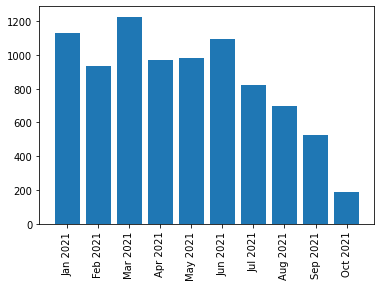

In [0]:
Completion_dict=Completion.rdd\
    .collectAsMap()

import matplotlib.pyplot as plt
plt.bar(range(len(Completion_dict)), list(Completion_dict.values()), align='center')
plt.xticks(range(len(Completion_dict)), list(Completion_dict.keys()),rotation=90)
plt.show()